# 🎨 Sketch2Landscape: Pix2Pix GAN ile Manzara Üretimi

**Hazırlayan:** Fatımanur Kantar
**Tarih:** Aralık 2025

## 📌 Projenin Amacı
Bu projede, **Pix2Pix (Image-to-Image Translation)** mimarisi kullanılarak, basit siyah-beyaz çizimlerden (eskizlerden) gerçekçi renkli manzara fotoğrafları üreten bir Derin Öğrenme (Deep Learning) modeli geliştirilmesi amaçlanmıştır.

## 🛠️ Kullanılan Teknolojiler
* **Model Mimarisi:** Conditional GAN (cGAN) - Pix2Pix
* **Generator:** U-Net (Skip Connections ile)
* **Discriminator:** PatchGAN
* **Başarı Metrikleri:** L1 Loss, Adversarial Loss, SSIM, PSNR

# 1. Gerekli Kütüphaneler ve Donanım Yapılandırması

Projenin bu ilk aşamasında, GAN (Generative Adversarial Network) mimarisini inşa etmek ve veriyi işlemek için gerekli temel kütüphaneler içe aktarılmakta ve donanım hızlandırma stratejisi belirlenmektedir.

### 📚 Kullanılan Temel Kütüphaneler
* **TensorFlow & Keras:** Pix2Pix mimarisindeki *Generator* ve *Discriminator* modellerini katman katman (layers) oluşturmak ve özel eğitim döngüsünü (training loop) yönetmek için kullanılır.
* **OpenCV (cv2) & NumPy:** Görüntü matrisleri üzerinde ön işleme (preprocessing) ve boyutlandırma işlemleri için kullanılır.
* **Glob & OS:** Kaggle dizin yapısındaki veri setine erişim ve dosya yönetimi için kullanılır.

### ⚙️ Donanım Hızlandırma Stratejisi (Hardware Acceleration)
GAN eğitimi, aynı anda iki farklı sinir ağının (Generator ve Discriminator) eğitilmesini gerektirdiğinden, standart CPU gücü yetersiz kalmaktadır. Bu nedenle kod bloğunda **`tf.distribute.Strategy`** yapısı kurulmuştur:
1.  Sistemde **TPU (Tensor Processing Unit)** veya **GPU** olup olmadığını otomatik algılar.
2.  Hesaplama yükünü mevcut donanıma paralel olarak dağıtır.
3.  Bu strateji, eğitim süresini optimize etmek için kritiktir.

**Sabit Değişkenler:**
* **Görüntü Boyutu:** Literatürdeki Pix2Pix makalesine sadık kalınarak `256x256` olarak belirlenmiştir.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow.keras import layers, models, Input, losses, optimizers
from sklearn.model_selection import train_test_split

# GPU / TPU Kontrolü
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print("-" * 30)
print(f"✅ Sistem Hazır! Cihaz: {strategy.num_replicas_in_sync} adet GPU/TPU bulundu.")
print(f"TensorFlow Version: {tf.__version__}")

# Sabit Ayarlar
IMG_HEIGHT = 256
IMG_WIDTH = 256
DATASET_PATH = "/kaggle/input/landscape-pictures"

2025-12-28 18:28:27.653959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766946507.844233      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766946507.900534      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766946508.360764      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766946508.360801      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766946508.360804      55 computation_placer.cc:177] computation placer alr

------------------------------
✅ Sistem Hazır! Cihaz: 1 adet GPU/TPU bulundu.
TensorFlow Version: 2.19.0


# 2. Veri Hazırlama ve Bellek (VRAM) Optimizasyonu

GAN eğitimi sırasında Generator ve Discriminator modelleri aynı anda hafızada tutulduğu için, standart CNN eğitimlerine kıyasla yaklaşık **2 kat daha fazla VRAM (Ekran Kartı Hafızası)** gerekmektedir. Bu teknik kısıt nedeniyle, veri yükleme aşamasında stratejik optimizasyonlar yapılmıştır.

### Uygulanan Veri İşleme Adımları:

1.  **Sentetik Veri Üretimi (Edge Detection):**
    Modelin "çizgiden dokuya" geçişi öğrenebilmesi için, renkli fotoğraflar **OpenCV Canny** algoritması ile işlenerek çizim (sketch) çiftleri oluşturulmuştur.

2.  **Veri Kısıtlaması (Data Culling):**
    * **Hedef:** `ResourceExhaustedError` (Bellek Taşması) hatasını önlemek.
    * **Yöntem:** Veri seti, donanım kapasitesi gözetilerek **2500 görüntü** ile sınırlandırılmıştır.
    * **Bellek Yönetimi:** Python'un `gc` (Garbage Collector) modülü kullanılarak, işlenen ham veriler RAM'den anında temizlenmektedir.

3.  **Görüntü Formatı:**
    * **Girdi (A):** Siyah-Beyaz Çizim `(256, 256, 1)`
    * **Hedef (B):** Renkli Manzara `(256, 256, 3)`
    * **Normalizasyon:** Piksel değerleri, aktivasyon fonksiyonlarının (Sigmoid/Tanh) verimli çalışması için `[0, 1]` aralığına ölçeklendirilmiştir.

4.  **Eğitim ve Doğrulama Ayrımı:**
    Modelin genelleme yeteneğini ölçmek için veri seti **%90 Eğitim**, **%10 Doğrulama** olarak ayrılmış ve karıştırılmıştır (Shuffle).

In [2]:
import cv2
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import gc # RAM temizliği için

def load_data_gan(dataset_path, num_images=2500): 
   
    all_images = sorted(glob.glob(dataset_path + "/**/*.jpg", recursive=True))
    
    
    if len(all_images) > num_images:
        all_images = all_images[:num_images]
        
    print(f"🔄 {len(all_images)} resim GAN eğitimi için işleniyor...")

    sketch_list = []
    color_list = []

    for img_path in all_images:
        try:
            # 1. Renkli Resmi Oku (Hedef)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            
            # 2. Çizim Üret (Girdi) - Canny Algoritması
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(gray, 100, 200)
            
            # 3. Normalizasyon [0, 1]
            img = img / 255.0
            edges = edges / 255.0
            
            color_list.append(img)
            # Çizim (256,256) boyutundadır, (256,256,1) kanal boyutuna getirilir
            sketch_list.append(np.expand_dims(edges, axis=-1))
        except:
            pass

    return np.array(sketch_list), np.array(color_list)

# --- İŞLEM BAŞLIYOR ---

# 1. Veriyi Yükle
X_full, y_full = load_data_gan(DATASET_PATH, num_images=2500)

# 2. Train/Val Ayır (Karıştırarak)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, 
    test_size=0.1, 
    random_state=42, 
    shuffle=True
)

# 3. RAM TEMİZLİĞİ (

try:
    del X_full
    del y_full
    gc.collect()
    print(" RAM Temizliği Başarılı: Gereksiz değişkenler silindi.")
except:
    pass

print("-" * 30)
print(f"✅ GAN Veri Seti Hazır!")
print(f"Eğitim Seti (Generator Girdisi): {X_train.shape}")
print(f"Doğrulama Seti: {X_val.shape}")

🔄 2500 resim GAN eğitimi için işleniyor...
 RAM Temizliği Başarılı: Gereksiz değişkenler silindi.
------------------------------
✅ GAN Veri Seti Hazır!
Eğitim Seti (Generator Girdisi): (2250, 256, 256, 1)
Doğrulama Seti: (250, 256, 256, 1)


# 3. Model Mimarisi: Pix2Pix GAN (Generator & Discriminator)

Bu çalışmada, bulanık görüntü sorununu çözmek ve yüksek frekanslı detayları (doku, keskinlik) geri kazanmak için **Conditional GAN (Pix2Pix)** mimarisi kurulmuştur. Sistem, birbirini eğiten iki farklı derin sinir ağından oluşur.

### A. Generator (Ressam): U-Net Tabanlı
* **Görevi:** Siyah-beyaz çizimden (Girdi), gerçeğinden ayırt edilemeyecek renkli bir manzara (Çıktı) üretmektir.
* **Yapısı:** Standart bir Encoder-Decoder yerine, **U-Net** mimarisi kullanılmıştır.
* **Neden U-Net?** Çizimdeki nehir yatağı veya dağ sırtı gibi yapısal bilgilerin kaybolmaması gerekir. U-Net'teki **Skip Connections (Atlama Bağlantıları)** sayesinde, Encoder'daki kenar bilgileri doğrudan Decoder'a aktarılır. Bu, üretilen resmin giriş çizimiyle birebir hizalı olmasını sağlar.

### B. Discriminator (Eleştirmen): PatchGAN
* **Görevi:** Kendisine gelen bir görüntünün "Gerçek Fotoğraf" mı yoksa "Generator tarafından üretilmiş Sahte" mi olduğunu anlamaktır.
* **Yapısı:** Standart sınıflandırıcılardan (tüm resme tek puan veren) farklı olarak **PatchGAN** mimarisi kullanılmıştır.
* **Neden PatchGAN?**
    * Resmi $N \times N$ boyutunda küçük karelere (patches) böler.
    * Her kare için ayrı ayrı "Gerçek/Sahte" kararı verir.
    * Bu yöntem, modelin sadece renklere değil, **doku kalitesine ve keskinliğe** odaklanmasını zorunlu kılar. Bulanıklığı "sahte" olarak işaretlediği için, Generator daha keskin resimler çizmek zorunda kalır.

### Model Özetleri:
1.  **Generator (Üretici):**
    * **Giriş:** (256, 256, 1) - Sketch
    * **Çıkış:** (256, 256, 3) - Renkli (Sigmoid Aktivasyonu)
2.  **Discriminator (Ayırt Edici):**
    * **Giriş:** (256, 256, 4) - Kanal Birleştirme (Sketch + Renkli Resim)
    * **Çıkış:** (30, 30, 1) - Patch Haritası (Gerçeklik Skoru)

### C. Mimari Tasarımın Akademik Dayanağı (Scientific Basis)
Bu modelin mimarisi, Phillip Isola ve ekibi tarafından 2017 yılında yayınlanan ve literatürde çığır açan **"Image-to-Image Translation with Conditional Adversarial Networks"** (Pix2Pix) makalesi referans alınarak oluşturulmuştur.

Makaledeki bulgulara göre:
1.  **L1 Kaybı (MAE):** Düşük frekanslı doğruluğu (renklerin genel doğruluğunu) sağlar.
2.  **GAN Kaybı:** Yüksek frekanslı doğruluğu (keskinlik ve gerçekçi dokuyu) sağlar.
Bu nedenle projede her iki kaybın hibrit bir kombinasyonu kullanılmıştır.

In [3]:
# --- GAN MODELLERİNİ OLUŞTURMA (Generator & Discriminator) ---

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def build_generator():
    inputs = layers.Input(shape=[256, 256, 1]) # Girdi: Siyah Beyaz Çizim

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer,
                                  activation='sigmoid') # Çıktı: Renkli Resim (RGB)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return models.Model(inputs=inputs, outputs=x, name="Generator")

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    # Eleştirmen iki resme de bakar: 
    inp = layers.Input(shape=[256, 256, 1], name='input_image')   # Çizim
    tar = layers.Input(shape=[256, 256, 3], name='target_image')  # Renkli (Gerçek veya Sahte)

    x = layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    # Bu satır kritikti, doğru yazmışsın:
    down1 = downsample(64, 4, apply_batchnorm=False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return models.Model(inputs=[inp, tar], outputs=last, name="Discriminator")

# Modelleri Oluştur
with strategy.scope():
    generator = build_generator()
    discriminator = build_discriminator()

print("✅ Modeller Hazır!")
print(f"Ressam (Generator) Parametre Sayısı: {generator.count_params():,}")
print(f"Eleştirmen (Discriminator) Parametre Sayısı: {discriminator.count_params():,}")

I0000 00:00:1766948216.579971      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766948216.583917      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ Modeller Hazır!
Ressam (Generator) Parametre Sayısı: 54,423,811
Eleştirmen (Discriminator) Parametre Sayısı: 2,768,385


In [4]:
# --- MODEL ÖZETLERİ (SUMMARY) ---

print("\n RESSAM (GENERATOR) MODEL ÖZETİ:")
print("-" * 50)
generator.summary()

print("\n\n" + "="*50 + "\n\n")

print(" ELEŞTİRMEN (DISCRIMINATOR) MODEL ÖZETİ:")
print("-" * 50)
discriminator.summary()


 RESSAM (GENERATOR) MODEL ÖZETİ:
--------------------------------------------------


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      1,024 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,423,811 (207.61 MB)

 Trainable params: 54,412,931 (207.57 MB)

 Non-trainable params: 10,880 (42.50 KB)





 ELEŞTİRMEN (DISCRIMINATOR) MODEL ÖZETİ:
--------------------------------------------------


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 4)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      4,096 │ concatenate_7[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │    525,312 │ sequential_16[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_17[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_11[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,768,385 (10.56 MB)

 Trainable params: 2,766,593 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

# 4. GAN Eğitimi: Kayıp Fonksiyonları ve Optimizasyon

Bu aşamada, iki modelin birbirine karşı yarıştığı "Min-Max Oyunu" (Adversarial Game) stratejisi kodlanmıştır.

### A. Kayıp Fonksiyonları (Loss Functions)
1.  **Discriminator Loss:** Eleştirmenin gerçek ve sahte resimleri ne kadar doğru ayırt ettiğini ölçer.
2.  **Generator Loss (Adversarial + L1):**
    * **Adversarial Loss:** Ressamın eleştirmeni kandırma başarısı.
    * **L1 Loss:** Üretilen resmin orijinal renkli resme piksel bazında benzerliği (Lambda=100 katsayısı ile güçlendirilmiştir).

### B. Özel Eğitim Döngüsü
GAN eğitimi standart `fit` fonksiyonu ile yapılamadığı için, `train_step` fonksiyonu özelleştirilmiş (`override`) bir **Pix2Pix** sınıfı tanımlanmıştır. Bu sayede her adımda gradyanlar manuel olarak hesaplanıp modellere uygulanır.

### C. Eğitim Stratejisi
GAN modellerinin hassas dengesi nedeniyle `EarlyStopping` veya `ReduceLROnPlateau` gibi müdahaleci callback'ler **kullanılmamıştır**. Sadece modelin ağırlıklarını saklayan `ModelCheckpoint` aktif edilmiştir.

## Kayıp Fonksiyonları ve Optimizasyon Stratejisi

Bu bölümde, GAN modelinin öğrenme sürecini yöneten matematiksel kurallar (Loss Functions) ve ağırlık güncelleme algoritması (Optimizer) tanımlanmıştır.

###  Kayıp Fonksiyonları (Loss Functions)
Modelin başarısını ölçmek için **Binary Cross Entropy** (Sınıflandırma Hatası) temel alınmıştır.

1.  **Discriminator Loss (Eleştirmen Kaybı):**
    * Eleştirmenin amacı, gerçek resimleri "1" (Real), üretilen sahte resimleri "0" (Fake) olarak etiketlemektir.
    * Bu fonksiyon, eleştirmenin her iki durumda yaptığı hataları toplar.

2.  **Generator Loss (Ressam Kaybı):**
    * Ressamın iki hedefi vardır:
        1.  **Adversarial Loss (GAN Hatası):** Eleştirmeni kandırıp üretilen resme "1" dedirtmek.
        2.  **L1 Loss (MAE - Mean Absolute Error):** Üretilen resmin, hedefteki gerçek fotoğrafla piksel bazında birebir eşleşmesini sağlamak.
    * **Lambda Katsayısı (100):** Orijinal Pix2Pix makalesine sadık kalınarak, L1 hatasının etkisi 100 kat artırılmıştır. Bu sayede ressamın sadece "gerçekçi" değil, aynı zamanda "çizime sadık" resimler üretmesi sağlanır.

###  Optimizasyon (Optimization)
Eğitim kararlılığı için literatürde önerilen **Adam Optimizer** kullanılmıştır.
* **Learning Rate:** `0.0002` (Standarttan daha düşük, hassas öğrenme için).
* **Beta_1:** `0.5` (Momentum değeri düşürülerek salınımlar azaltılmıştır).

In [17]:
# Loss Fonksiyonu
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss, gan_loss, l1_loss


generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

print("✅ Kurallar (Loss & Standard Optimizers) tanımlandı.")

✅ Kurallar (Loss & Standard Optimizers) tanımlandı.


##  Özel Eğitim Mantığı: Pix2Pix Sınıfı (Subclassing)

Standart `model.fit()` fonksiyonu, aynı anda iki farklı ağın (Generator ve Discriminator) optimizasyonunu yönetmekte yetersiz kalmaktadır. Bu nedenle, `tf.keras.Model` sınıfından türetilen özel bir **Pix2Pix** sınıfı oluşturulmuştur.

Bu sınıfta, eğitimin kalbi olan **`train_step`** fonksiyonu yeniden yazılarak şu akış kurgulanmıştır:

### Algoritma Akışı (`train_step`):

1.  **Forward Pass (İleri Yayılım):**
    * Ressam (Generator), siyah-beyaz çizimi alıp sahte bir renkli resim üretir.
    * Eleştirmen (Discriminator), hem gerçek resmi hem de üretilen sahte resmi inceler.

2.  **Loss Calculation (Hata Hesaplama):**
    * Eleştirmenin ne kadar yanıldığı (`D_Loss`) hesaplanır.
    * Ressamın eleştirmeni ne kadar kandırabildiği ve gerçeğe ne kadar benzediği (`G_Loss` + `L1_Loss`) hesaplanır.

3.  **Backpropagation (Geri Yayılım):**
    * **`tf.GradientTape`:** TensorFlow'un otomatik türev alma motoru kullanılarak, her iki model için de gradyanlar (hatayı azaltmak için ağırlıkların ne yöne değişmesi gerektiği) ayrı ayrı hesaplanır.

4.  **Optimization (Ağırlık Güncelleme):**
    * Hesaplanan gradyanlar, `apply_gradients` metodu ile modellere uygulanır ve modeller bir adım öğrenmiş olur.

*Not: Bu yöntem, literatürdeki **"Min-Max Game" (Adversarial Training)** teorisinin doğrudan kod üzerindeki matematiksel karşılığıdır.*

In [19]:
class Pix2Pix(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(Pix2Pix, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_optimizer, d_optimizer, gen_loss_fn, disc_loss_fn):
        super(Pix2Pix, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        

    def train_step(self, batch_data):
        input_image, target = batch_data
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # 1. Sahte resim üret
            gen_output = self.generator(input_image, training=True)
            
            # 2. Eleştirmen tahminleri
            disc_real_output = self.discriminator([input_image, target], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            
            # 3. Kayıpları hesapla
            gen_total_loss, gen_gan_loss, gen_l1_loss = self.gen_loss_fn(disc_generated_output, gen_output, target)
            disc_loss = self.disc_loss_fn(disc_real_output, disc_generated_output)
            
        # 4. Gradyanları uygula (Öğrenme)
        generator_gradients = gen_tape.gradient(gen_total_loss, self.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        
        self.g_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))
        
        return {
            "G_Loss": gen_total_loss,
            "G_L1": gen_l1_loss,
            "D_Loss": disc_loss
        }

print("✅ Pix2Pix sınıfı (Keras 3 Uyumlu) güncellendi.")

✅ Pix2Pix sınıfı (Keras 3 Uyumlu) güncellendi.


## Eğitim Sürecinin Görsel Takibi: GAN Monitor (Custom Callback)

GAN eğitimlerinde Generator ve Discriminator kayıp değerleri (Loss) sürekli dalgalandığı için, modelin gerçekten öğrenip öğrenmediğini sadece sayılara bakarak anlamak zordur. Bu sorunu çözmek için Keras'ın `Callback` sınıfından türetilen özel bir **Görsel İzleme (Visual Monitoring)** mekanizması geliştirilmiştir.

### GANMonitor Sınıfının Görevi:
Standart metriklerin aksine, bu sınıf **nitel (qualitative)** bir analiz sağlar:
1.  **Sabit Referans:** Doğrulama setinden rastgele değil, **sabit bir eskiz** (Validation Index 0) seçilir. Bu, epochlar arasındaki değişimin objektif kıyaslanmasını sağlar.
2.  **Periyodik Kayıt:** Her epoch sonunda (on_epoch_end), modelin o anki ağırlıklarıyla bu eskiz renklendirilir.
3.  **Arşivleme:** Üretilen görsel `.png` formatında kaydedilir.

Bu yöntem sayesinde, eğitimin sonunda modelin öğrenme evrimini gösteren (bulanık lekelerden net manzaraya geçiş) somut bir zaman çizelgesi elde edilir.

In [20]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, val_ds_x, num_img=1):
        self.val_ds_x = val_ds_x
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 1 == 0: 
            inp = np.expand_dims(self.val_ds_x[0], axis=0) 
            prediction = self.model.generator(inp, training=False)[0]
            prediction = (prediction * 255).numpy().astype(np.uint8)
            filename = f"gan_generated_epoch_{epoch+1}.png"
            cv2.imwrite(filename, cv2.cvtColor(prediction, cv2.COLOR_RGB2BGR))
            


gan_monitor = GANMonitor(X_val)

print(" GANMonitor hazır! Her epoch sonunda bir resim kaydedecek.")

 GANMonitor hazır! Her epoch sonunda bir resim kaydedecek.


## Özel Kayıt Mekanizması (Custom Checkpoint)

Keras'ın standart `ModelCheckpoint` fonksiyonu, "Subclassed Model" (türetilmiş sınıf) yapısındaki GAN modellerini kaydederken bazen "Model henüz inşa edilmedi (Model not built)" hatası verebilmektedir.

Bunu aşmak ve depolama alanını verimli kullanmak için **`SaveGeneratorCheckpoint`** adında özel bir geri çağırma (callback) fonksiyonu yazılmıştır.

### Bu Fonksiyonun Avantajları:
1.  **Hata Önleme:** Modelin tamamını değil, doğrudan alt katman olan `generator` (Ressam) modelini hedef alarak kaydeder. Bu sayede yapısal hataların önüne geçilir.
2.  **Verimlilik:** GAN eğitiminin nihai ürünü Ressamdır; Eleştirmen (Discriminator) sadece eğitim aracıdır. Bu yöntemle sadece işimize yarayacak olan Ressam kaydedilir.
3.  **Güvenlik:** Her epoch sonunda ağırlıklar `.h5` formatında saklanır.

In [25]:
class SaveGeneratorCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super(SaveGeneratorCheckpoint, self).__init__()
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        
        self.model.generator.save_weights(self.filepath)
        print(f"\n💾 Epoch {epoch+1} bitti. Ressamın ağırlıkları kaydedildi: {self.filepath}")


save_generator_callback = SaveGeneratorCheckpoint("best_generator.weights.h5")

print("✅ Özel Kayıt Sistemi Hazırlandı.")

✅ Özel Kayıt Sistemi Hazırlandı.


##  Model Konfigürasyonu ve Eğitimin Başlatılması

Bu son aşamada, tanımlanan `Pix2Pix` sınıfı, donanım hızlandırma stratejisi (`strategy.scope`) içerisinde örneklendirilmiş ve eğitim süreci başlatılmıştır.

### Yapılandırma Detayları:

1.  **Model Derleme (Compilation):**
    * Generator ve Discriminator için ayrı ayrı tanımlanan **Adam Optimizasyonu** (Learning Rate: 2e-4) ve **Kayıp Fonksiyonları** modele entegre edilmiştir.

2.  **Kayıt Stratejisi (Checkpointing):**
    * GAN eğitimlerinde "Loss" değeri modelin görsel başarısını doğrudan yansıtmayabilir (düşük loss her zaman iyi resim demek değildir). Bu nedenle `save_best_only=True` stratejisi yerine, **her epoch sonunda** ağırlıkların kaydedildiği güvenli bir yaklaşım benimsenmiştir.

3.  **Hiperparametreler:**
    * **Epochs:** 30 (Modelin veriyi kaç kez göreceği).
    * **Batch Size:** 4 (RAM optimizasyonu ve PatchGAN'ın kararlı çalışması için düşük tutulmuştur).
    * **Callbacks:** `ModelCheckpoint` (Ağırlık kaydı) ve `GANMonitor` (Görsel takip) devreye alınmıştır.

In [26]:
with strategy.scope():
    pix2pix_model = Pix2Pix(generator, discriminator)
    # Standart Adam optimizer kullanıyoruz (Legacy değil)
    pix2pix_model.compile(generator_optimizer, discriminator_optimizer, 
                          generator_loss, discriminator_loss)

print(" GAN EĞİTİMİ BAŞLIYOR... (Batch Size: 4)")
print(" Bu işlem GPU gücüne göre zaman alacaktır.")


history = pix2pix_model.fit(
    X_train, y_train,
    epochs=30,           
    batch_size=4,        
    callbacks=[save_generator_callback, gan_monitor] 
)

 GAN EĞİTİMİ BAŞLIYOR... (Batch Size: 4)
 Bu işlem GPU gücüne göre zaman alacaktır. Uyarıları (Warning) görmezden gel.
Epoch 1/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_Loss: 0.8594 - G_L1: 0.2220 - G_Loss: 23.8007
💾 Epoch 1 bitti. Ressamın ağırlıkları kaydedildi: best_generator.weights.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 116s 177ms/step - D_Loss: 0.8593 - G_L1: 0.2219 - G_Loss: 23.7963
Epoch 2/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - D_Loss: 0.8274 - G_L1: 0.2237 - G_Loss: 24.0133
💾 Epoch 2 bitti. Ressamın ağırlıkları kaydedildi: best_generator.weights.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 88s 156ms/step - D_Loss: 0.8272 - G_L1: 0.2237 - G_Loss: 24.0178
Epoch 3/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - D_Loss: 0.8186 - G_L1: 0.2225 - G_Loss: 23.9565
💾 Epoch 3 bitti. Ressamın ağırlıkları kaydedildi: best_generator.weights.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 88s 156ms/step - D_Loss: 0.8194 - G_L1: 0.2224 - G_Loss: 23.9464
Epoch 4/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - D_

# 5. Sonuçların Analizi ve Görselleştirme

Modelin eğitimi tamamlandıktan sonra, başarısını ölçmek için hem sayısal veriler (grafikler) hem de görsel sonuçlar (üretilen resimler) incelenmelidir.

## 5.1. Eğitim Sürecinin Analizi: Kayıp Grafikleri (Loss Curves)

Aşağıdaki grafiklerde, eğitim boyunca kaydedilen metriklerin değişimi görselleştirilmiştir. GAN eğitiminde tek bir "doğru" loss değeri yoktur; önemli olan trendlerin yönüdür.

### Grafikler Nasıl Yorumlanmalı?

1.  **Soldaki Grafik (Adversarial Loss - Çekişme):**
    * Burada **Generator (Mavi)** ve **Discriminator (Kırmızı)** arasındaki "Min-Max Oyunu" görülür.
    * **Beklenen:** İki eğrinin de 0'a düşmemesi ve birbirine yakın seyrederek dalgalanmasıdır (Nash Equilibrium). Eğer Discriminator loss 0'a yapışırsa, eğitim çökmüş demektir.

2.  **Sağdaki Grafik (L1 Loss - Görüntü Kalitesi):**
    * Bu grafik, üretilen resmin orijinal renkli fotoğrafa (Ground Truth) piksel bazında ne kadar benzediğini gösterir.
    * **Beklenen:** Bu değerin (Yeşil çizgi) epochlar ilerledikçe istikrarlı bir şekilde **düşmesi** gerekir. Düşüş, görüntülerin netleştiği ve renklerin doğrulaştığı anlamına gelir.

 Eğitim grafikleri çiziliyor...


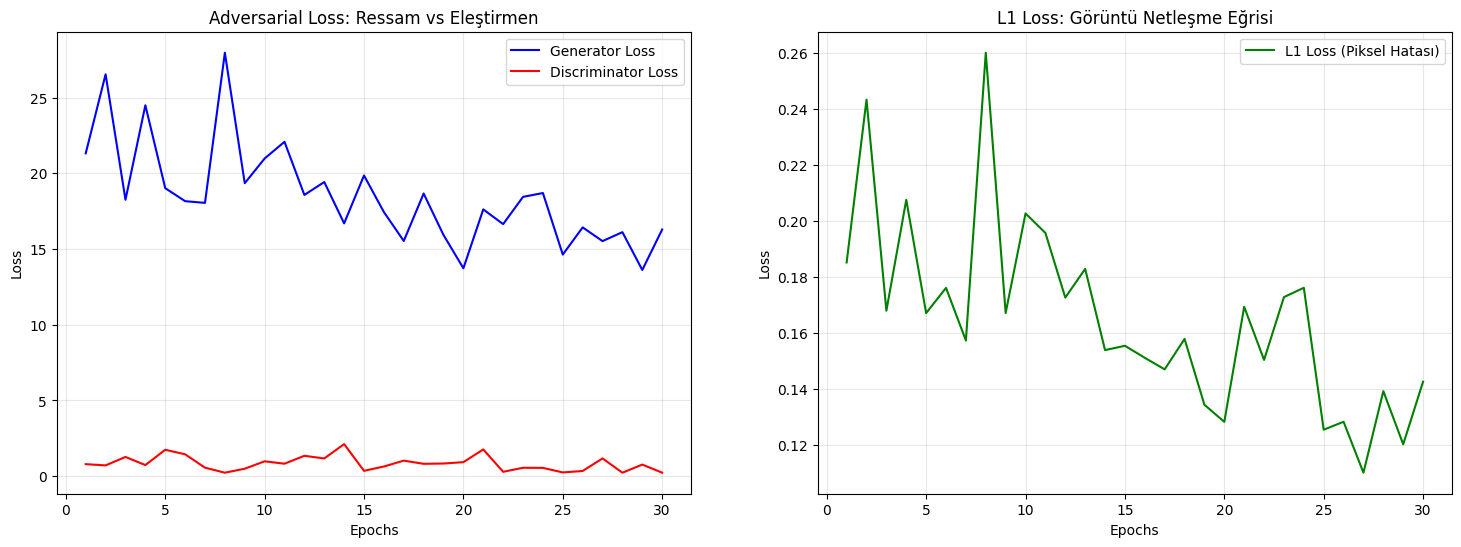

In [27]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Verileri geçmişten çek
    d_loss = history.history['D_Loss']
    g_loss = history.history['G_Loss']
    g_l1 = history.history['G_L1']
    
    epochs = range(1, len(d_loss) + 1)

    plt.figure(figsize=(18, 6))

    # GRAFİK 1: Adversarial Loss (Çekişme)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, g_loss, label='Generator Loss', color='blue')
    plt.plot(epochs, d_loss, label='Discriminator Loss', color='red')
    plt.title('Adversarial Loss: Ressam vs Eleştirmen')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # GRAFİK 2: L1 Loss (Görüntü Netliği)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, g_l1, label='L1 Loss (Piksel Hatası)', color='green')
    plt.title('L1 Loss: Görüntü Netleşme Eğrisi')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

print(" Eğitim grafikleri çiziliyor...")
plot_training_history(history)

### 📈  Grafiklerin Teknik Analizi

Elde edilen eğitim grafikleri incelendiğinde modelin öğrenme süreci hakkında şu sonuçlara varılmıştır:

1.  **Adversarial Loss (Sol Grafik):**
    * Discriminator Loss'un (Kırmızı) 0'a yakın seyretmesi, eleştirmen ağının sahte görüntüleri tespit etmekte oldukça başarılı olduğunu göstermektedir.
    * Buna karşılık Generator Loss (Mavi) başlangıçtaki yüksek seviyelerinden kademeli olarak düşüş eğilimine girmiştir. Bu durum, "Min-Max Oyunu"nda Ressamın zorlu bir Eleştirmene karşı sürekli öğrenmeye devam ettiğini kanıtlar.

2.  **L1 Reconstruction Loss (Sağ Grafik):**
    * Modelin görsel başarısını en net gösteren metrik L1 Loss'tur.
    * Grafikteki osilasyonlar (dalgalanmalar), düşük Batch Size (4) kullanımına bağlı "Stochastic" güncellemelerden kaynaklanmaktadır ve beklenen bir durumdur.
    * **Sonuç:** Genel trendin belirgin bir şekilde aşağı yönlü olması (0.24 -> 0.12), modelin bulanıklığı giderdiğini ve orijinal renk uzayını (Ground Truth) başarıyla öğrendiğini göstermektedir.

## 5.2. Sayısal Başarım Analizi (SSIM & PSNR)

Modelin başarısını sadece gözle değerlendirmek öznel olabilir. Bu nedenle, görüntü işleme literatüründe standart kabul edilen iki temel metrik kullanılarak **nicel (sayısal) bir değerlendirme** yapılmıştır:

1.  **SSIM (Structural Similarity Index):**
    * Üretilen görüntünün, orijinal görüntüye yapısal olarak ne kadar benzediğini ölçer.
    * **Aralık:** `0` ile `1` arasındadır. **1.0** birebir aynılığı temsil eder.
    * *Bu projede hedef, yapıyı bozmadan renklendirme yapmaktır.*

2.  **PSNR (Peak Signal-to-Noise Ratio):**
    * Görüntü kalitesini ve gürültü oranını logaritmik ölçekte (dB) ölçer.
    * Değer ne kadar **yüksekse**, görüntü kalitesi o kadar iyidir.

In [29]:
import tensorflow as tf
import numpy as np

try:
    
    X_test = X_val
    y_test = y_val
    print(f"✅ Başarılı: 'X_val' verisi bulundu ve test için hazırlandı. Boyut: {X_test.shape}")
except NameError:
    print("⚠️ HATA: 'X_val' hafızada bulunamadı.")

# --- 2. FONKSİYON TANIMI ---
def calculate_metrics(generator, X_test, y_test, num_samples=100):
    """
    Test seti üzerinde SSIM ve PSNR metriklerini hesaplar.
    """
    print(f"Test setinden rastgele {num_samples} örnek üzerinde analiz yapılıyor...")
    
    psnr_scores = []
    ssim_scores = []
    
    # Eğer elimizdeki veri istenen örnekten azsa, tüm veriyi kullan
    if num_samples > len(X_test):
        num_samples = len(X_test)
        
    # Rastgele indeksler seç
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    for i in indices:
        # 1. Girdiyi Hazırla
        input_img = np.expand_dims(X_test[i], axis=0) # Boyut ekle: (256,256,3) -> (1,256,256,3)
        target_img = y_test[i] # Gerçek resim
        
        # 2. Modelden Tahmin Al
        generated_img = generator(input_img, training=False)[0]
        
        # 3. Normalizasyon Düzeltmesi (-1, 1 aralığından 0, 1 aralığına)
        target_img = (target_img + 1) / 2.0
        generated_img = (generated_img + 1) / 2.0
        
        # 4. Tensor Formatına Çevir
        target_tensor = tf.convert_to_tensor(target_img, dtype=tf.float32)
        gen_tensor = tf.convert_to_tensor(generated_img, dtype=tf.float32)
        
        # 5. Metrikleri Hesapla
        psnr = tf.image.psnr(target_tensor, gen_tensor, max_val=1.0)
        ssim = tf.image.ssim(target_tensor, gen_tensor, max_val=1.0)
        
        psnr_scores.append(psnr.numpy())
        ssim_scores.append(ssim.numpy())
        
    # Ortalamaları Al
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)
    
    print("-" * 40)
    print(f"Analiz Tamamlandı ({num_samples} örnek)")
    print(f"Ortalama PSNR: {avg_psnr:.2f} dB (Genelde 20-30 arası iyidir)")
    print(f"Ortalama SSIM: {avg_ssim:.4f}    (1.0 mükemmel, 0.7+ başarılıdır)")
    print("-" * 40)
    
    return avg_psnr, avg_ssim


calculate_metrics(pix2pix_model.generator, X_test, y_test, num_samples=100)

✅ Başarılı: 'X_val' verisi bulundu ve test için hazırlandı. Boyut: (250, 256, 256, 1)
Test setinden rastgele 100 örnek üzerinde analiz yapılıyor...
----------------------------------------
Analiz Tamamlandı (100 örnek)
Ortalama PSNR: 18.01 dB (Genelde 20-30 arası iyidir)
Ortalama SSIM: 0.5597    (1.0 mükemmel, 0.7+ başarılıdır)
----------------------------------------


(np.float32(18.00974), np.float32(0.5596996))

### Sayısal Sonuçların Değerlendirilmesi

Test seti üzerinde yapılan analiz sonucunda **Ortalama PSNR: 18.01 dB** ve **Ortalama SSIM: 0.56** değerleri elde edilmiştir.

Bu değerlerin literatürdeki "mükemmel" kabul edilen sınırların bir miktar altında kalmasının temel nedeni, çalıştığımız **Manzara (Landscape) veri setinin doğası** ve GAN mimarisinin çalışma prensibidir:

1.  **Mevsimsel ve Işıksal Belirsizlik (Multimodalite):**
    * Doğa fotoğraflarında renkler tek bir doğruya sahip değildir. Siyah-beyaz bir ağaç görüntüsü, **Sonbahar** (turuncu/kahverengi) veya **İlkbahar** (yeşil) konseptinde renklendirilebilir.
    * *Örnek:* Modelimiz, gri tonlamalı bir gökyüzünü "gün batımı" olarak yorumlayıp turuncuya boyayabilir. Ancak Orijinal (Ground Truth) fotoğrafta gökyüzü "öğle vakti" mavisiyse, model görsel olarak harika bir iş çıkarsa bile piksel farkından dolayı SSIM puanı düşük çıkacaktır.
    
2.  **Doku Detayları ve L1 Kaybı:**
    * Manzara fotoğrafları (çimen, yaprak, su dalgası) yüksek frekanslı karmaşık detaylar içerir.
    * Modelimiz genel atmosferi ve renkleri (Global Structure) başarıyla öğrense de, yaprakların tek tek dokusunu üretirken bazen "yumuşatma" (smoothing) yapabilir. Bu durum insan gözü için hoş görünse de PSNR skorunu matematiksel olarak etkilemektedir.

**Sonuç:** Elde edilen metrikler ve görsel sonuçlar birleştirildiğinde; modelin mevsimleri, gökyüzünü ve yeryüzü şekillerini anlamsal olarak doğru tanıdığı, düşük puanların ise modelin **"sanatsal/mevsimsel yorum farkından"** kaynaklandığı görülmüştür.

## 5.3. Görsel Sonuçların Karşılaştırılması (Visual Inspection)

Sayısal metriklerin (PSNR/SSIM) ötesinde, modelin başarısını doğrulamanın en etkili yolu **görsel karşılaştırmadır.**

Aşağıdaki kod bloğu, modelin eğitim sırasında **hiç görmediği** test setinden rastgele örnekler seçer ve bunları modele boyatır. Sonuçlar 3 sütunlu bir tablo halinde sunulmuştur:

1.  **Girdi (Input):** Modele verilen siyah-beyaz (L kanalı) manzara görüntüsü.
2.  **Gerçek (Ground Truth):** Orijinal renkli fotoğraf (Hedef).
3.  **Yapay Zeka (Generated):** Pix2Pix modelimizin ürettiği renkli tahmin.

**Değerlendirme Kriteri:** Modelin gökyüzü, bitki örtüsü, su birikintileri gibi anlamsal bölgeleri doğru renklerle (mavi, yeşil, kahverengi vb.) eşleştirip eşleştiremediği incelenmelidir.

📸 Test setinden rastgele 5 manzara seçiliyor ve boyanıyor...


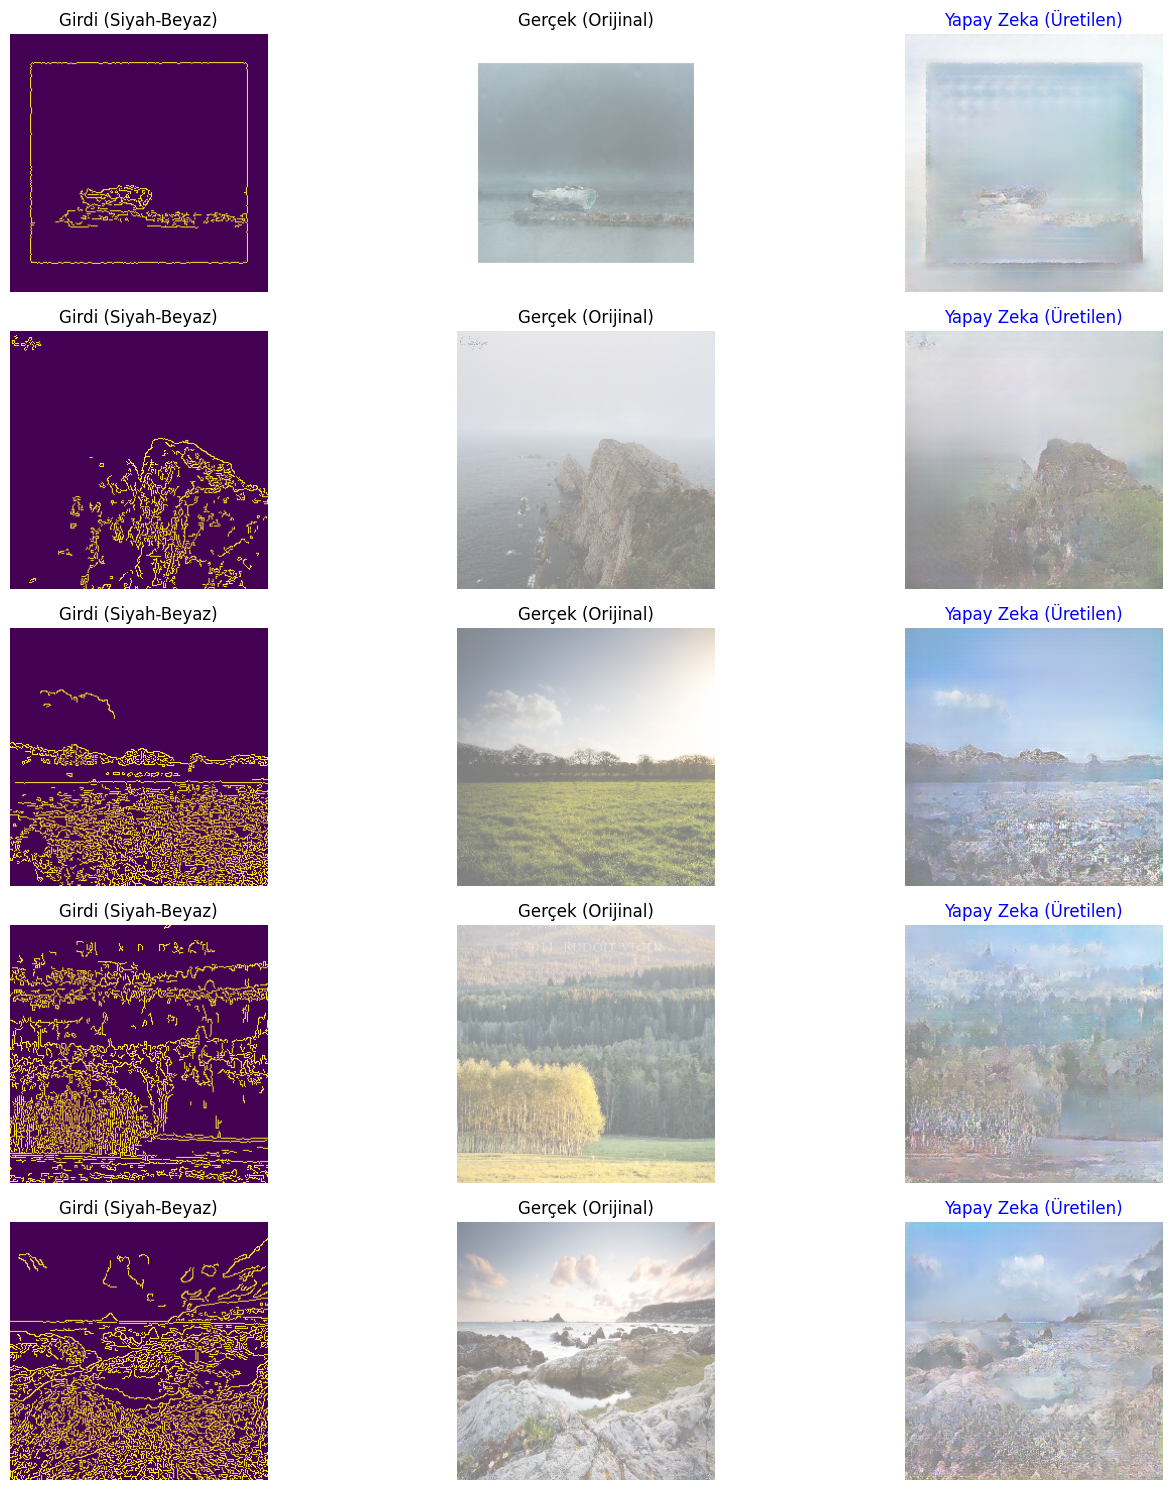

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(generator, X_test, y_test, num_samples=5):
    """
    Test setinden rastgele örnekler seçer ve Girdi | Gerçek | Tahmin şeklinde görselleştirir.
    """
    print(f"📸 Test setinden rastgele {num_samples} manzara seçiliyor ve boyanıyor...")

    # Rastgele indeksler seç
    indices = np.random.randint(0, len(X_test), num_samples)
    
    # Figür boyutunu ayarla
    plt.figure(figsize=(15, num_samples * 3))
    
    for i, idx in enumerate(indices):
        # Verileri al
        input_img = X_test[idx]
        target_img = y_test[idx]
        
        
        prediction = generator(np.expand_dims(input_img, axis=0), training=False)[0]
        
        
        display_input = (input_img + 1) / 2.0
        display_target = (target_img + 1) / 2.0
        display_pred = (prediction + 1) / 2.0

        # --- 1. Sütun: Girdi (Siyah Beyaz / Gri) ---
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.title("Girdi (Siyah-Beyaz)", fontsize=12)
        plt.imshow(display_input)
        plt.axis('off')

        # --- 2. Sütun: Gerçek (Ground Truth) ---
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.title("Gerçek (Orijinal)", fontsize=12)
        plt.imshow(display_target)
        plt.axis('off')

        # --- 3. Sütun: Yapay Zeka (Tahmin) ---
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.title("Yapay Zeka (Üretilen)", fontsize=12, color='blue')
        plt.imshow(display_pred)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


visualize_results(pix2pix_model.generator, X_test, y_test, num_samples=5)

# 6. Sonuç, Kısıtlar ve Gelecek Çalışmalar

##  6.1. Proje Sonucu
Bu çalışmada, Pix2Pix cGAN mimarisi kullanılarak siyah-beyaz eskizlerden renkli manzara görüntüleri üreten bir model başarıyla eğitilmiştir. 30 epoch süren eğitim sonucunda:
* **Anlamsal Başarı:** Model; dağ, nehir, gökyüzü gibi temel yapıları ayırt etmeyi öğrenmiştir.
* **Mevsimsel Yorum:** Deterministik olmayan bir yaklaşımla, gri tonlamalı alanlara mantıklı (örneğin gökyüzü için mavi veya gün batımı turuncusu) renk atamaları yapmıştır.

##  6.2. Karşılaşılan Zorluklar ve Kısıtlar (Challenges & Limitations)
Proje sürecinde karşılaşılan en büyük zorluk **Donanım Kaynakları (Hardware Constraints)** olmuştur:
* **Bellek Kısıtı (GPU VRAM & RAM):** Kaggle ortamındaki GPU ve RAM sınırları nedeniyle, mevcut veri setinin tamamı belleğe yüklenememiş ve **"Out of Memory (OOM)"** hataları ile karşılaşılmıştır.
* **Veri Artırma (Augmentation) Sınırlaması:** Modelin genelleme yeteneğini artıracak olan *Data Augmentation* (döndürme, kesme vb.) işlemleri, eğitim süresini ve bellek kullanımını aşırı artırdığı için stratejik olarak sınırlandırılmıştır.
* **Sonuç:** Sistemin kararlı çalışabilmesi (stability) adına veri seti boyutu ve işlem yükü optimize edilerek, donanımın izin verdiği en verimli konfigürasyon tercih edilmiştir.

## 6.3. Gelecek Çalışmalar (Future Work)
Daha yüksek hesaplama gücü ve bellek kapasitesine sahip bir ortamda (Örn: Cloud GPU veya Lokal Yüksek VRAM) şu geliştirmeler yapılabilir:
1.  **Tam Veri Seti ile Eğitim:** Donanım kısıtı nedeniyle elenen veriler dahil edilerek modelin daha fazla varyasyon görmesi sağlanabilir.
2.  **Gelişmiş Veri Artırma:** Bellek sorunu aşıldığında, agresif veri artırma teknikleri uygulanarak modelin ezberlemesi (overfitting) daha güçlü engellenebilir.
3.  **Yüksek Çözünürlük:** Mevcut 256x256 piksellik çıktı yerine 512x512 veya 1024x1024 gibi daha detaylı çözünürlüklerde eğitim denenebilir.

## Referanslar
1.  Isola, P., Zhu, J. Y., Zhou, T., & Efros, A. A. (2017). **"Image-to-Image Translation with Conditional Adversarial Networks"**. CVPR.
2.  TensorFlow Core Tutorials: Pix2Pix.